In [1]:
import sys
sys.path.append("/home/amisery/SemesterProject")
from models.engine_nodecl import NodeClassificationEngine
from data.sfgd_datamodules import NodeCL_h5dataset
from data.plotting_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
ckpt_path = "/home/amisery/SemesterProject/tb_logs/my_model/version_9/checkpoints/epoch=47-step=10128.ckpt"
model = NodeClassificationEngine.load_from_checkpoint(ckpt_path, map_location="cpu")

In [4]:
dataset_h5 = NodeCL_h5dataset("/home/amisery/SemesterProject/out_cap_1000.h5")

In [15]:
def get_batch_from_data(dataset, idx):
    elem = dataset[idx]
    coords, label = elem["coords"], elem["values"]
    mask = torch.ones(len(coords))
    return coords[None,:], label[None,:], mask[None,:]

In [36]:
def model_inference(dataset, idx):
    coords, label, mask = get_batch_from_data(dataset,idx)
    return (torch.argmax(model(coords,mask), dim=2) +1).view(-1,1)

In [52]:
def display_3D_from_coords_labels(coords, vals,ax):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    
    for i in range(1,4):
        cat_coords =coords[(vals==i).squeeze(1),:]
        plot = ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return plot

In [109]:
def plot_truth_pred(dataset,model,idx):
    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1,projection='3d')
    display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["values"],ax)
    plt.title("Event #%d, %d hits, ground truth"%(idx, len(dataset.get_raw(idx)['coords'])), fontsize = 15)
    ax = fig.add_subplot(1,2,2,projection='3d')
    ax= display_3D_from_coords_labels(dataset_h5.get_raw(idx)['coords'][:,:3], model_inference(dataset,idx),ax)
    plt.title("Model Prediction", fontsize = 15)
    # plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

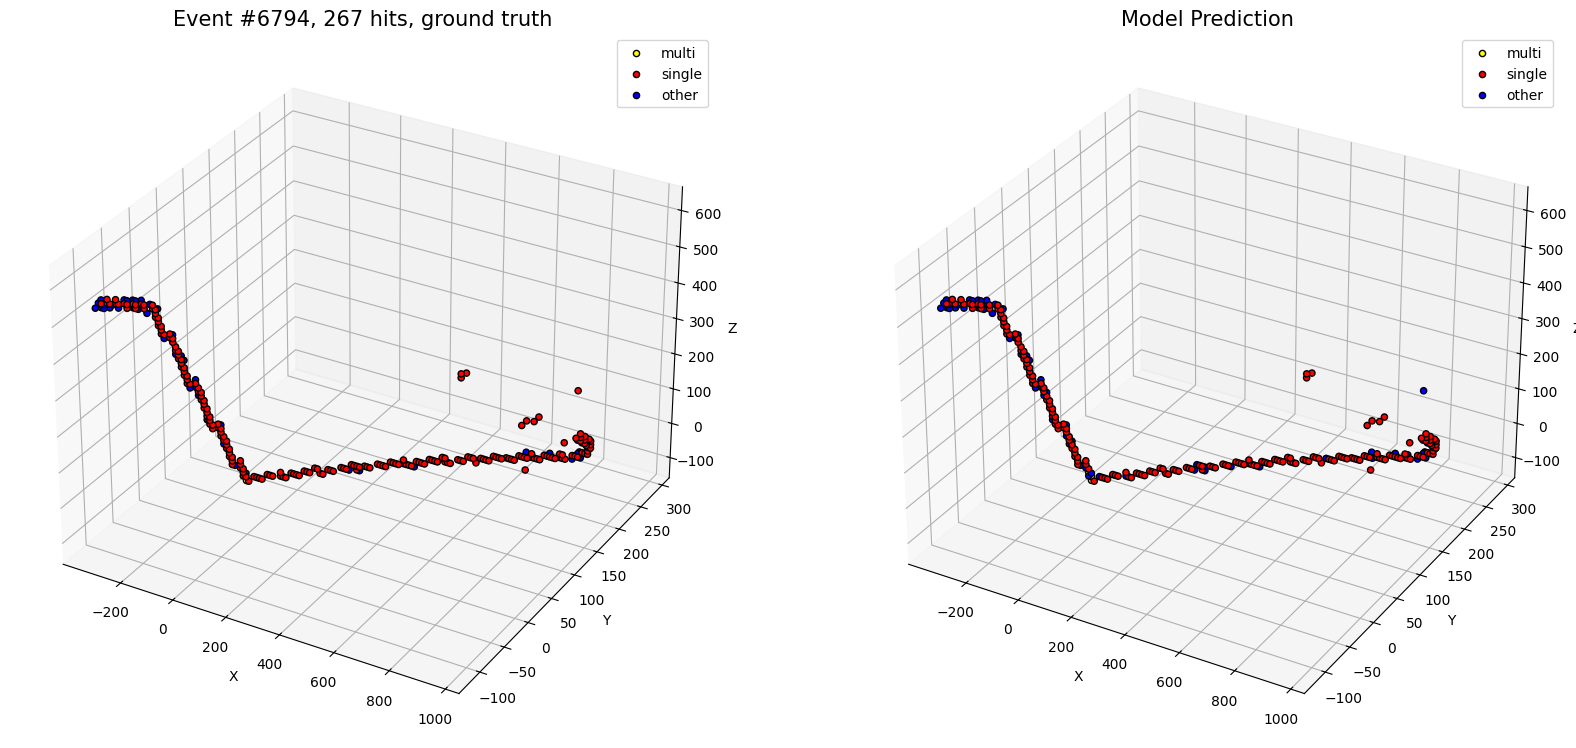

In [120]:
plot_truth_pred(dataset_h5,model,np.random.randint(len(dataset_h5)))

In [11]:
print(dataset_h5.get_raw(3)['coords'][:,:3].size())

torch.Size([216, 3])


In [35]:
dataset_h5.get_raw(3)["values"].shape

torch.Size([216, 1])

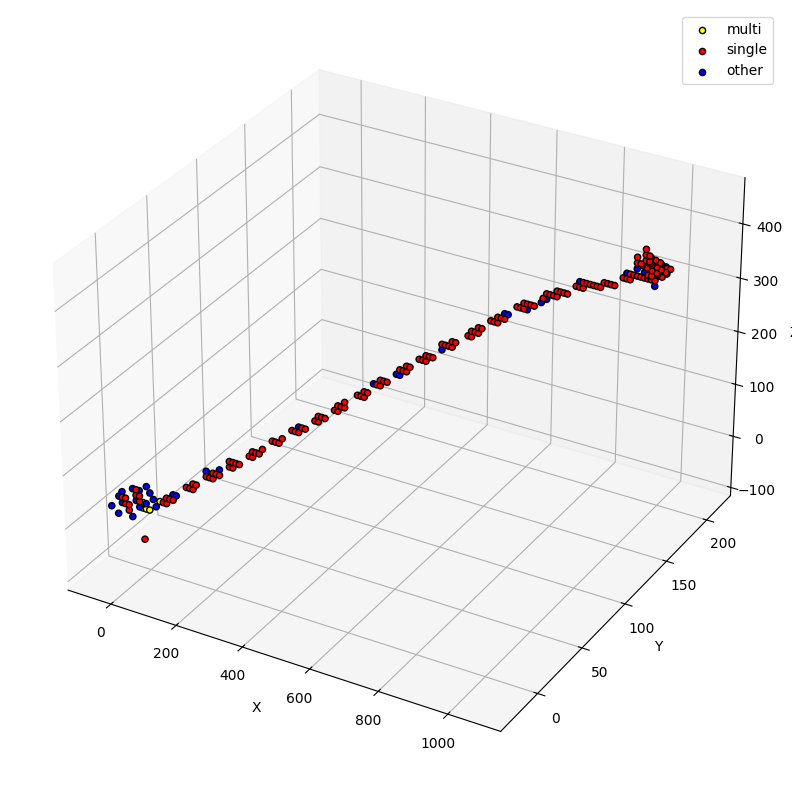

In [38]:
display_3D_from_coords_labels(dataset_h5.get_raw(3)['coords'][:,:3], model_inference(dataset_h5,3))